# Балансировка стаканов с компотом с помощью DQN-агента

Работу выполнили студенты группы БСМО-11-25:

* Аршинов Владислав
* Елохин Валерий
* Савин Даниил
* Якушенко Иван



In [16]:
# Установка необходимых библиотек
!pip install gymnasium stable-baselines3 matplotlib numpy tensorboard

In [17]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

In [47]:
# Задаем параметры модели и ее обучения
INITIAL_STATE = np.array([5, 3, 6, 2, 9], dtype=np.int32)     # Начальное состояние
MAX_CAPACITY = np.max(INITIAL_STATE)                          # Максимальная емкость стакана
TARGET_VOLUME = np.sum(INITIAL_STATE) // 5                    # Целевой объем
MAX_STEPS = 200                                               # Максимальное число шагов в эпизоде
TIMESTEPS_COUNT = 1000000                                     # Число шагов обучения

Создадим среду для задачи.

Наблюдение:
- массив из 5 целых чисел, представляющих текущие объемы в стаканах.

Каждое действие кодирует переливание из стакана A в стакан B:
  - источник = действие // 4;
  - цель = действие % 4, скорректированное так, чтобы не совпадать с источником.

Награды:
- -1 за первое действие или смену источника;
- 0 за продолжение переливания из того же источника;
- -10 за попытку невозможного действия;
- +100 за успешное достижение баланса;
- -100 за превышение лимита шагов.

Завершение эпизода:
- Все стаканы содержат целевой объем (успех);
- Превышение лимита шагов.

In [48]:
class GlassesEnv(gym.Env):
    def __init__(self):
        super(GlassesEnv, self).__init__()

        # Пространство наблюдений: 5 целых чисел от 0 до MAX_CAPACITY
        self.observation_space = spaces.Box(
            low=0,
            high=MAX_CAPACITY,
            shape=(5,),
            dtype=np.int32
        )

        # Пространство действий: 5 источников * 4 цели = 20 действий
        self.action_space = spaces.Discrete(20)

        # Инициализация состояния
        self.state = None
        self.last_source = None  # Источник последнего успешного действия
        self.steps = 0  # Счетчик шагов в эпизоде

    def _decode_action(self, action):
        """Декодирование действия в источник и приемник"""
        source = action // 4
        target = action % 4

        # Корректировка целевого стакана: пропускаем источник
        target = target if target < source else target + 1
        return source, target

    def reset(self, seed=None, options=None):
        """Сброс среды в начальное состояние"""
        super().reset(seed=seed)
        self.state = INITIAL_STATE.copy()
        self.last_source = None
        self.steps = 0
        return self.state.copy(), {}

    def step(self, action):
        """Выполнение шага среды"""
        self.steps += 1
        source, target = self._decode_action(action)

        # Флаги для определения награды
        invalid_action = False
        done = False
        truncated = False
        success = False

        # Проверка валидности действия
        if self.state[source] <= 0 or self.state[target] >= MAX_CAPACITY:
            invalid_action = True
            reward = -10  # Штраф за невозможное действие
        else:
            # Выполнение переливания
            new_state = self.state.copy()
            new_state[source] -= 1
            new_state[target] += 1
            self.state = new_state

            # Расчет награды за смену источника
            if self.last_source is None:  # Первое действие в эпизоде
                reward = -1
                self.last_source = source
            elif source == self.last_source:  # Тот же источник
                reward = 0
            else:  # Смена источника
                reward = -1
                self.last_source = source

        # Проверка достижения цели
        if np.all(self.state == TARGET_VOLUME):
            done = True
            success = True
            reward += 100  # Награда за успех

        # Проверка лимита шагов
        if self.steps >= MAX_STEPS and not done:
            truncated = True
            done = True
            reward = -100  # Штраф за превышение лимита

        # Информация для отладки
        info = {
            'invalid_action': invalid_action,
            'success': success,
            'steps': self.steps
        }

        return self.state.copy(), reward, done, truncated, info

In [49]:
# Callback для сбора статистики обучения
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_reward = 0
        self.episode_count = 0

    def _on_step(self) -> bool:
        # Получение информации о завершении эпизода из info
        if 'terminal_observation' in self.locals['infos'][0]:
            self.episode_rewards.append(self.current_reward)
            self.current_reward = 0
            self.episode_count += 1
        else:
            self.current_reward += self.locals['rewards'][0]
        return True

In [50]:
# Создание среды
env = GlassesEnv()

# Инициализация DQN-агента
model = DQN(
    "MlpPolicy",
    env,
    verbose=0,
    buffer_size=32768,
    learning_starts=1024,
    batch_size=128,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.3,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.01,
    gradient_steps=1,
    tensorboard_log="./dqn_glasses_tensorboard/"
)

# Callback для логирования наград
reward_logger = RewardLoggerCallback()

In [51]:
# Обучение агента
model.learn(
    total_timesteps=TIMESTEPS_COUNT,
    callback=reward_logger,
    progress_bar=True
)

Output()

In [52]:
# Демонстрация работы обученного агента
print("Демонстрация работы обученного агента:")
obs, _ = env.reset()
total_reward = 0
step_count = 0

while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1

    print(f"Шаг {step_count}: Действие: {1 + action//4}->{1 + action%4 + bool(action%4 > action//4)}, Состояние: {obs}, Награда: {reward}")

    if terminated or truncated:
        print(f"\nЭпизод завершен! Итоговая награда: {total_reward:.2f}")
        print(f"Количество шагов: {step_count}")
        print(f"Финальное состояние: {obs}")
        success = np.all(obs == TARGET_VOLUME)
        print(f"Успех: {'Да' if success else 'Нет'}")
        break


Демонстрация работы обученного агента:
Шаг 1: Действие: 5->4, Состояние: [5 3 6 3 8], Награда: -1
Шаг 2: Действие: 5->4, Состояние: [5 3 6 4 7], Награда: 0
Шаг 3: Действие: 5->4, Состояние: [5 3 6 5 6], Награда: 0
Шаг 4: Действие: 5->2, Состояние: [5 4 6 5 5], Награда: 0
Шаг 5: Действие: 5->2, Состояние: [5 5 6 5 4], Награда: 0
Шаг 6: Действие: 3->5, Состояние: [5 5 5 5 5], Награда: 99

Эпизод завершен! Итоговая награда: 98.00
Количество шагов: 6
Финальное состояние: [5 5 5 5 5]
Успех: Да


Кривая обучения сохранена в 'learning_curve.png'


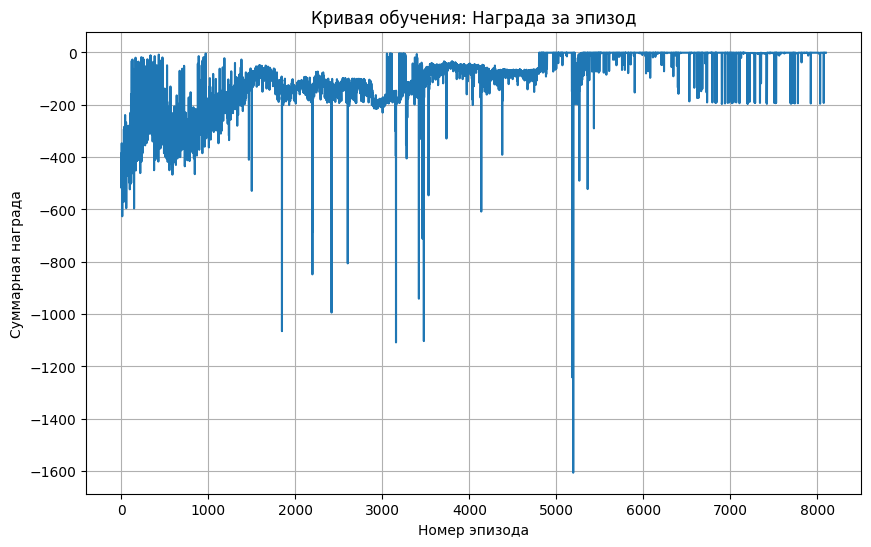

In [53]:
# Генерация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(reward_logger.episode_rewards)
plt.title('Кривая обучения: Награда за эпизод')
plt.xlabel('Номер эпизода')
plt.ylabel('Суммарная награда')
plt.grid(True)

# Сохранение графика
plt.savefig('learning_curve.png')
print("Кривая обучения сохранена в 'learning_curve.png'")